<a href="https://colab.research.google.com/github/eshikapathak/Personalized-Federated-Learning/blob/main/Basic/FedAvg_and_FedSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FedAvg

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [119]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [120]:
def iid_loader(dataset, num_clients=100, batch_size=10):
    total = len(dataset)
    indices = torch.randperm(total).tolist()
    data_per_client = total // num_clients
    client_indices = [indices[i * data_per_client:(i + 1) * data_per_client] for i in range(num_clients)]

    client_loaders = [
        DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=True)
        for indices in client_indices
    ]
    return client_loaders

In [137]:
def non_iid_loader(dataset, num_clients=100, batch_size=10, classes_per_user=2, high_prob=0.6, low_prob=0.4):
    # Helper function to get number of classes and labels
    def get_num_classes_samples(data):
        if isinstance(data.targets, list):
            labels = np.array(data.targets)
        else:
            labels = data.targets.numpy()
        classes, num_samples = np.unique(labels, return_counts=True)
        return len(classes), num_samples, labels

    # Helper function to generate data split based on class partitions
    def gen_data_split(num_samples, labels, class_partitions):
        data_class_idx = {i: np.where(labels == i)[0] for i in range(num_classes)}
        for idx_list in data_class_idx.values():
            random.shuffle(idx_list)

        user_data_idx = [[] for _ in range(num_clients)]
        for usr_i in range(num_clients):
            for c, p in zip(class_partitions['class'][usr_i], class_partitions['prob'][usr_i]):
                end_idx = int(p * num_samples[c])
                user_data_idx[usr_i].extend(data_class_idx[c][:end_idx])
                data_class_idx[c] = data_class_idx[c][end_idx:]
        return user_data_idx

    num_classes, num_samples, labels = get_num_classes_samples(dataset)
    count_per_class = (classes_per_user * num_clients) // num_classes

    # Generating class partitions
    class_dict = {i: {'prob': np.random.uniform(low_prob, high_prob, size=count_per_class).tolist()} for i in range(num_classes)}
    for probs in class_dict.values():
        total = sum(probs['prob'])
        probs['prob'] = [p / total for p in probs['prob']]

    # Assign classes and probabilities to each client
    class_partitions = {'class': [], 'prob': []}
    available_classes = list(range(num_classes)) * count_per_class
    random.shuffle(available_classes)
    for _ in range(num_clients):
        client_classes = random.sample(available_classes, classes_per_user)
        for c in client_classes:
            available_classes.remove(c)
        client_probs = [class_dict[c]['prob'].pop() for c in client_classes]
        class_partitions['class'].append(client_classes)
        class_partitions['prob'].append(client_probs)

    # Generating data splits
    user_data_idx = gen_data_split(num_samples, labels, class_partitions)

    # Creating data loaders
    client_data_loaders = []
    for indices in user_data_idx:
        subset = Subset(dataset, indices)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        client_data_loaders.append(loader)

    return client_data_loaders

In [134]:
batch_size = 64
num_clients = 100
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

iid_client_train_loader = iid_loader(train_data, num_clients, batch_size)
non_iid_client_train_loader = non_iid_loader(train_data, num_clients, batch_size, classes_per_user=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Models

In [124]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
        )

    def forward(self, x):
        x = x.flatten(1)
        x = self.nn(x)
        return x

class CNN(nn.Module):
    def __init__(self, in_channels=3, n_kernels=16, out_dim=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, n_kernels, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_kernels, 2 * n_kernels, 5)
        self.fc1 = nn.Linear(2 * n_kernels * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [77]:
from torchsummary import summary
mlp = SimpleMLP().to(device)
summary(mlp,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
              ReLU-2                  [-1, 200]               0
            Linear-3                  [-1, 200]          40,200
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [125]:
cnn = CNN().to(device)
summary(cnn,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 10, 10]          12,832
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Linear-5                  [-1, 120]          96,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 121,182
Trainable params: 121,182
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.46
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


In [79]:
criterion = nn.CrossEntropyLoss()

In [81]:
def train(model, client_train_loader, epochs, optimizer):
    model.train()
    for _ in range(epochs):
        for _, (data, target) in enumerate(client_train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return model

def evaluate(model):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax( dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    acc = correct / total
    return acc

In [82]:
def running_model_average(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key]*scale
    else:
        for key in current:
            current[key] = current[key] + next[key]*scale
    return current

In [92]:
def experiments(global_model, client_frac, epochs, lr, train_loader, max_rounds):
    accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        clients = np.random.choice(np.arange(num_clients), int(num_clients*client_frac), replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None
        for i, c in enumerate(clients):
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients*client_frac, c))
            local_model = copy.deepcopy(global_model).to(device)
            optimizer = torch.optim.SGD(local_model.parameters(), lr = lr, momentum=0.9, weight_decay=0.0001)
            local_model = train(local_model, train_loader[c], epochs=epochs, optimizer=optimizer)
            running_avg = running_model_average(running_avg, local_model.state_dict(), 1/(num_clients*client_frac))
        
        global_model.load_state_dict(running_avg)
        val_acc = evaluate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        accuracy.append(val_acc)

    return np.array(accuracy)

In [146]:
cnn = CNN()
cnn_iid_10 = copy.deepcopy(cnn)
acc_cnn_iid_10_1_1 = experiments(cnn_iid_10, client_frac=0.1, epochs=5, lr=0.05, train_loader=non_iid_client_train_loader, max_rounds=1000)
print(acc_cnn_iid_10_1_1)

starting round 0
clients:  [82 74 49 39 66 60 79 23 34 98]
round 0, starting client 1/10.0, id: 82
round 0, starting client 2/10.0, id: 74
round 0, starting client 3/10.0, id: 49
round 0, starting client 4/10.0, id: 39
round 0, starting client 5/10.0, id: 66
round 0, starting client 6/10.0, id: 60
round 0, starting client 7/10.0, id: 79
round 0, starting client 8/10.0, id: 23
round 0, starting client 9/10.0, id: 34
round 0, starting client 10/10.0, id: 98
round 0, validation acc: 0.1
starting round 1
clients:  [75 51 56  7 62 67 72 20 88 81]
round 1, starting client 1/10.0, id: 75
round 1, starting client 2/10.0, id: 51
round 1, starting client 3/10.0, id: 56
round 1, starting client 4/10.0, id: 7
round 1, starting client 5/10.0, id: 62
round 1, starting client 6/10.0, id: 67
round 1, starting client 7/10.0, id: 72
round 1, starting client 8/10.0, id: 20
round 1, starting client 9/10.0, id: 88
round 1, starting client 10/10.0, id: 81
round 1, validation acc: 0.1586
starting round 2
cli

In [87]:
mlp = SimpleMLP()
mlp_iid_10 = copy.deepcopy(mlp)
acc_mlp_iid_10 = experiments(mlp_iid_10, client_frac=0.1, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_10)

starting round 0
clients:  [99 20 50 12 76 82 61 77 22 91]
round 0, starting client 1/10.0, id: 99
round 0, starting client 2/10.0, id: 20
round 0, starting client 3/10.0, id: 50
round 0, starting client 4/10.0, id: 12
round 0, starting client 5/10.0, id: 76
round 0, starting client 6/10.0, id: 82
round 0, starting client 7/10.0, id: 61
round 0, starting client 8/10.0, id: 77
round 0, starting client 9/10.0, id: 22
round 0, starting client 10/10.0, id: 91
round 0, validation acc: 0.8123
starting round 1
clients:  [17 81 45 49 71 62  2 92  5 10]
round 1, starting client 1/10.0, id: 17
round 1, starting client 2/10.0, id: 81
round 1, starting client 3/10.0, id: 45
round 1, starting client 4/10.0, id: 49
round 1, starting client 5/10.0, id: 71
round 1, starting client 6/10.0, id: 62
round 1, starting client 7/10.0, id: 2
round 1, starting client 8/10.0, id: 92
round 1, starting client 9/10.0, id: 5
round 1, starting client 10/10.0, id: 10
round 1, validation acc: 0.8755
starting round 2
c

In [94]:
mlp = SimpleMLP()
mlp_iid_20 = copy.deepcopy(mlp)
acc_mlp_iid_20 = experiments(mlp_iid_20, client_frac=0.2, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_20)

starting round 0
clients:  [84 35 10 26 31 49 47 56 61 50 42 40 78 37 97 11 46 29 91 30]
round 0, starting client 1/20.0, id: 84
round 0, starting client 2/20.0, id: 35
round 0, starting client 3/20.0, id: 10
round 0, starting client 4/20.0, id: 26
round 0, starting client 5/20.0, id: 31
round 0, starting client 6/20.0, id: 49
round 0, starting client 7/20.0, id: 47
round 0, starting client 8/20.0, id: 56
round 0, starting client 9/20.0, id: 61
round 0, starting client 10/20.0, id: 50
round 0, starting client 11/20.0, id: 42
round 0, starting client 12/20.0, id: 40
round 0, starting client 13/20.0, id: 78
round 0, starting client 14/20.0, id: 37
round 0, starting client 15/20.0, id: 97
round 0, starting client 16/20.0, id: 11
round 0, starting client 17/20.0, id: 46
round 0, starting client 18/20.0, id: 29
round 0, starting client 19/20.0, id: 91
round 0, starting client 20/20.0, id: 30
round 0, validation acc: 0.8048
starting round 1
clients:  [26  0 53 11  3 22 23 67 36 87 32 81 49 7

In [93]:
mlp = SimpleMLP()
mlp_iid_50 = copy.deepcopy(mlp)
acc_mlp_iid_50 = experiments(mlp_iid_50, client_frac=0.5, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_50)

starting round 0
clients:  [15 80 56  7 22 28 82 52 20 97 44 10 13 19 86 69  5 40 26 18 79 88 21  2
 43 57 25 49 81 74 48 87 47 76 27  6 41 61 35 71 51 89 59 42 83 36 29 68
 31 33]
round 0, starting client 1/50.0, id: 15
round 0, starting client 2/50.0, id: 80
round 0, starting client 3/50.0, id: 56
round 0, starting client 4/50.0, id: 7
round 0, starting client 5/50.0, id: 22
round 0, starting client 6/50.0, id: 28
round 0, starting client 7/50.0, id: 82
round 0, starting client 8/50.0, id: 52
round 0, starting client 9/50.0, id: 20
round 0, starting client 10/50.0, id: 97
round 0, starting client 11/50.0, id: 44
round 0, starting client 12/50.0, id: 10
round 0, starting client 13/50.0, id: 13
round 0, starting client 14/50.0, id: 19
round 0, starting client 15/50.0, id: 86
round 0, starting client 16/50.0, id: 69
round 0, starting client 17/50.0, id: 5
round 0, starting client 18/50.0, id: 40
round 0, starting client 19/50.0, id: 26
round 0, starting client 20/50.0, id: 18
round 0, s

In [95]:
mlp = SimpleMLP()
mlp_iid_100 = copy.deepcopy(mlp)
acc_mlp_iid_100 = experiments(mlp_iid_100, client_frac=1, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_100)

starting round 0
clients:  [66 25 53 22 12 31 99 67 56  7 94 88 44 55 35 77 34 18  3 61 69 19 98 17
  1 89 51 84 97 14 76 13 43 30 27  9 83 93 32 73 33 81 37 40  0 57  8 92
 41 46 64  4 11 45 74 71 78 79 65 72 96 70 16 68 47 80 48  6 86 36 63 15
 38 90 50 29 59 42 75 82 60  5 62 49 28 52 58 39 20 54 91 10  2 87 21 23
 85 24 26 95]
round 0, starting client 1/100, id: 66
round 0, starting client 2/100, id: 25
round 0, starting client 3/100, id: 53
round 0, starting client 4/100, id: 22
round 0, starting client 5/100, id: 12
round 0, starting client 6/100, id: 31
round 0, starting client 7/100, id: 99
round 0, starting client 8/100, id: 67
round 0, starting client 9/100, id: 56
round 0, starting client 10/100, id: 7
round 0, starting client 11/100, id: 94
round 0, starting client 12/100, id: 88
round 0, starting client 13/100, id: 44
round 0, starting client 14/100, id: 55
round 0, starting client 15/100, id: 35
round 0, starting client 16/100, id: 77
round 0, starting client 17/100, id: 

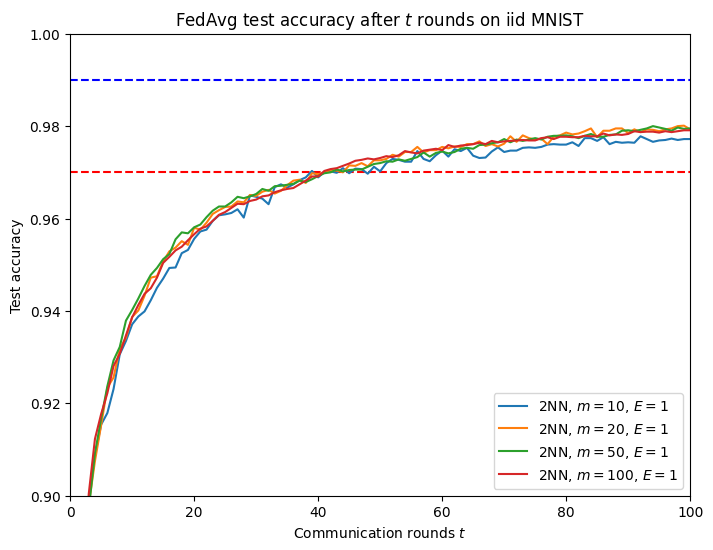

In [97]:
x = np.arange(1,101)
plt.figure(figsize=(8,6))

plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")

plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 100, 0.9, 1])

plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x, acc_mlp_iid_10, label='2NN, $m=10$, $E=1$')
plt.plot(x, acc_mlp_iid_20, label='2NN, $m=20$, $E=1$')
plt.plot(x, acc_mlp_iid_50, label='2NN, $m=50$, $E=1$')
plt.plot(x, acc_mlp_iid_100, label='2NN, $m=100$, $E=1$')

plt.legend()
plt.show()

In [110]:
cnn = CNN()
cnn_iid_10 = copy.deepcopy(cnn)
acc_cnn_iid_10 = experiments(cnn_iid_10, client_frac=0.1, epochs=5, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_cnn_iid_10)

starting round 0
clients:  [98 45 66 91 68  8 28  9 29 18]
round 0, starting client 1/10.0, id: 98
round 0, starting client 2/10.0, id: 45
round 0, starting client 3/10.0, id: 66
round 0, starting client 4/10.0, id: 91
round 0, starting client 5/10.0, id: 68
round 0, starting client 6/10.0, id: 8
round 0, starting client 7/10.0, id: 28
round 0, starting client 8/10.0, id: 9
round 0, starting client 9/10.0, id: 29
round 0, starting client 10/10.0, id: 18
round 0, validation acc: 0.9173
starting round 1
clients:  [67 21 20 12 59 69 80 27 87 79]
round 1, starting client 1/10.0, id: 67
round 1, starting client 2/10.0, id: 21
round 1, starting client 3/10.0, id: 20
round 1, starting client 4/10.0, id: 12
round 1, starting client 5/10.0, id: 59
round 1, starting client 6/10.0, id: 69
round 1, starting client 7/10.0, id: 80
round 1, starting client 8/10.0, id: 27
round 1, starting client 9/10.0, id: 87
round 1, starting client 10/10.0, id: 79
round 1, validation acc: 0.9557
starting round 2
c

In [111]:
cnn = CNN()
cnn_iid_20 = copy.deepcopy(cnn)
acc_cnn_iid_20 = experiments(cnn_iid_20, client_frac=0.2, epochs=5, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_cnn_iid_20)

starting round 0
clients:  [ 3 54  0 38 31  7 95  9 43 27  2 70 21 97 75 62 94 73 69  6]
round 0, starting client 1/20.0, id: 3
round 0, starting client 2/20.0, id: 54
round 0, starting client 3/20.0, id: 0
round 0, starting client 4/20.0, id: 38
round 0, starting client 5/20.0, id: 31
round 0, starting client 6/20.0, id: 7
round 0, starting client 7/20.0, id: 95
round 0, starting client 8/20.0, id: 9
round 0, starting client 9/20.0, id: 43
round 0, starting client 10/20.0, id: 27
round 0, starting client 11/20.0, id: 2
round 0, starting client 12/20.0, id: 70
round 0, starting client 13/20.0, id: 21
round 0, starting client 14/20.0, id: 97
round 0, starting client 15/20.0, id: 75
round 0, starting client 16/20.0, id: 62
round 0, starting client 17/20.0, id: 94
round 0, starting client 18/20.0, id: 73
round 0, starting client 19/20.0, id: 69
round 0, starting client 20/20.0, id: 6
round 0, validation acc: 0.9182
starting round 1
clients:  [58 34 91 94 22 68  8 73 54 76 66 97 67 38 65  

In [112]:
cnn = CNN()
cnn_iid_50 = copy.deepcopy(cnn)
acc_cnn_iid_50 = experiments(cnn_iid_50, client_frac=0.5, epochs=5, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_cnn_iid_50)

starting round 0
clients:  [69 44 51  8 45 46 93 91 32 11 20 87 22 57 54 84  7 60 16 17 43 31  0 23
  1 47 70 74 21  4 89  6 72 80 79 65 59 36 24 58 86 15 81 37  3 67 49 97
 98 61]
round 0, starting client 1/50.0, id: 69
round 0, starting client 2/50.0, id: 44
round 0, starting client 3/50.0, id: 51
round 0, starting client 4/50.0, id: 8
round 0, starting client 5/50.0, id: 45
round 0, starting client 6/50.0, id: 46
round 0, starting client 7/50.0, id: 93
round 0, starting client 8/50.0, id: 91
round 0, starting client 9/50.0, id: 32
round 0, starting client 10/50.0, id: 11
round 0, starting client 11/50.0, id: 20
round 0, starting client 12/50.0, id: 87
round 0, starting client 13/50.0, id: 22
round 0, starting client 14/50.0, id: 57
round 0, starting client 15/50.0, id: 54
round 0, starting client 16/50.0, id: 84
round 0, starting client 17/50.0, id: 7
round 0, starting client 18/50.0, id: 60
round 0, starting client 19/50.0, id: 16
round 0, starting client 20/50.0, id: 17
round 0, s

KeyboardInterrupt: 

In [ ]:
cnn = CNN()
cnn_iid_100 = copy.deepcopy(cnn)
acc_cnn_iid_100 = experiments(cnn_iid_100, client_frac=1, epochs=5, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_cnn_iid_100)

In [ ]:
x = np.arange(1,101)
plt.figure(figsize=(8,6))

plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")

plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 100, 0.9, 1])

plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x, acc_mlp_iid_10, label='2NN, $m=10$, $E=1$')
plt.plot(x, acc_mlp_iid_20, label='2NN, $m=20$, $E=1$')
plt.plot(x, acc_mlp_iid_50, label='2NN, $m=50$, $E=1$')
plt.plot(x, acc_mlp_iid_100, label='2NN, $m=100$, $E=1$')

plt.plot(x, acc_cnn_iid_10, label='CNN, $m=10$, $E=5$')
plt.plot(x, acc_cnn_iid_20, label='CNN, $m=20$, $E=5$')
plt.plot(x, acc_cnn_iid_50, label='CNN, $m=50$, $E=5$')
plt.plot(x, acc_cnn_iid_100, label='CNN, $m=100$, $E=5$')

plt.legend()
plt.show()

# FedSGD

Epoch 1: Global model accuracy: 0.8438
Epoch 2: Global model accuracy: 0.8754
Epoch 3: Global model accuracy: 0.8889
Epoch 4: Global model accuracy: 0.8959
Epoch 5: Global model accuracy: 0.9025
Epoch 6: Global model accuracy: 0.9064
Epoch 7: Global model accuracy: 0.9083
Epoch 8: Global model accuracy: 0.9115
Epoch 9: Global model accuracy: 0.9140
Epoch 10: Global model accuracy: 0.9164


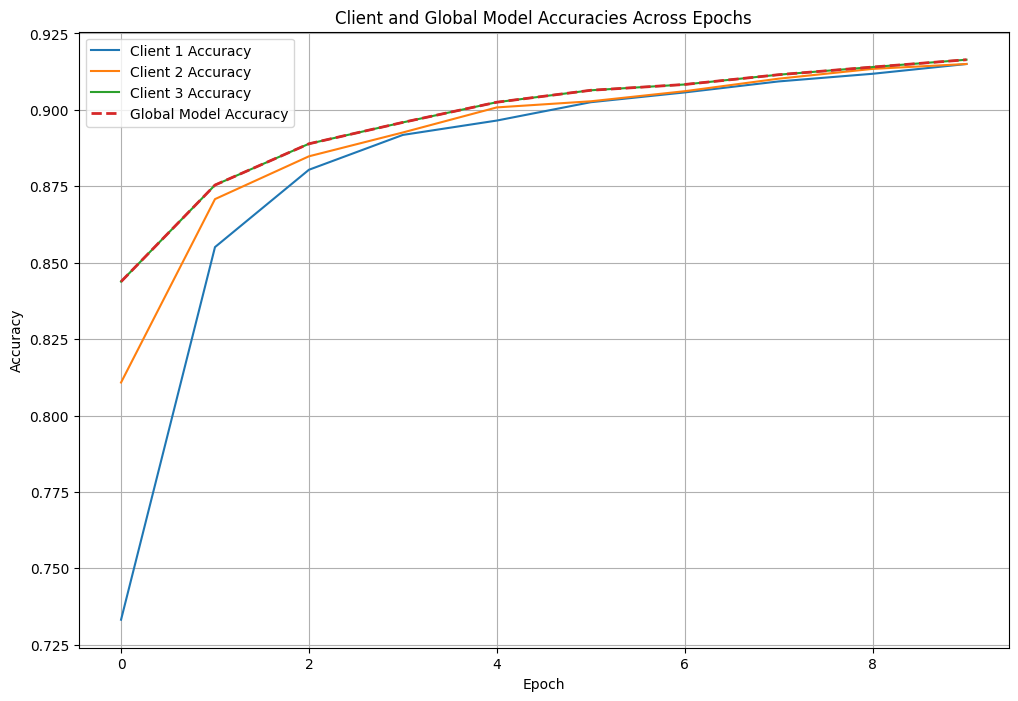

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split data for 3 clients
indices = torch.randperm(len(train_data)).tolist()
client_datasets = [Subset(train_data, indices[i::3]) for i in range(3)]
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model definition
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize global model and optimizers
global_model = SimpleMLP().to(device)
global_optimizer = optim.SGD(global_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

# Function to perform FedSGD
def fed_sgd(client_data, model, global_optimizer, criterion, device):
    global_optimizer.zero_grad()
    data, target = client_data
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    loss.backward()  # Gradients are computed here
    global_optimizer.step()  # Update using the gradients

# Evaluate function
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

# Training and evaluation
epochs = 10
global_accuracies = []
client_accuracies = [[] for _ in range(3)]

for epoch in range(epochs):
    client_loaders = [DataLoader(dataset, batch_size=64, shuffle=True) for dataset in client_datasets]
    for i, client_loader in enumerate(client_loaders):
        for client_data in client_loader:
            fed_sgd(client_data, global_model, global_optimizer, criterion, device)
        acc = evaluate(global_model, device, test_loader)
        client_accuracies[i].append(acc)
    global_acc = evaluate(global_model, device, test_loader)
    global_accuracies.append(global_acc)
    print(f'Epoch {epoch+1}: Global model accuracy: {global_acc:.4f}')

# Plot accuracies
plt.figure(figsize=(12, 8))
for i, accuracies in enumerate(client_accuracies):
    plt.plot(accuracies, label=f'Client {i+1} Accuracy')
plt.plot(global_accuracies, label='Global Model Accuracy', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Client and Global Model Accuracies Across Epochs')
plt.legend()
plt.grid(True)
plt.show()
